In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, mutual_info_score
from sklearn.model_selection import RandomizedSearchCV

In [37]:
#read the data 
df = pd.read_csv('icu_vitals.csv')
df

,hr,rr,spo2,sys,dia,monitor_alarm,doctor_alarm
0,94,15,100,163,81,False,False
1,88,15,99,128,62,False,False
2,82,17,100,103,50,False,False
3,89,18,100,139,83,False,False
4,95,26,100,153,73,False,False
...,...,...,...,...,...,...,...
4003,92,15,96,98,52,True,False
4004,83,22,96,109,53,True,False
4005,81,17,96,97,53,True,False
4006,77,19,98,113,53,False,False


In [38]:
# missing values
print(df.isnull().sum())
df.dropna(inplace=True)

hr               0
rr               0
spo2             0
sys              0
dia              0
monitor_alarm    0
doctor_alarm     0
dtype: int64


In [39]:
df.dtypes

hr               int64
rr               int64
spo2             int64
sys              int64
dia              int64
monitor_alarm     bool
doctor_alarm      bool
dtype: object

In [40]:
#identify which numeric parameters are most relevant for doctor alarms.
correlations = df.corr()
print(correlations['doctor_alarm'].sort_values(ascending=False))

doctor_alarm     1.000000
rr               0.456657
monitor_alarm    0.383396
hr               0.199740
sys              0.110059
dia              0.090647
spo2            -0.286053
Name: doctor_alarm, dtype: float64


In [41]:
# correlation between categorical variables
mutual_info_score(df.monitor_alarm, df.doctor_alarm)

0.08150960317149887

In [42]:
# select numeric columns
numeric_cols = df.select_dtypes(include=['int64']).columns.tolist()

# standardize numeric columns
scaler = StandardScaler()
df_numeric_scaled = scaler.fit_transform(df[numeric_cols])

#convert back to df 
df_numeric_scaled = pd.DataFrame(df_numeric_scaled, columns=numeric_cols)
df_scaled = pd.concat([df_numeric_scaled, df[['monitor_alarm', 'doctor_alarm']]], axis=1)
df_scaled

,hr,rr,spo2,sys,dia,monitor_alarm,doctor_alarm
0,0.424773,-0.900386,0.832213,1.930537,1.435544,False,False
1,0.060993,-0.900386,0.509941,0.398583,0.065899,False,False
2,-0.302787,-0.566937,0.832213,-0.695669,-0.799139,False,False
3,0.121623,-0.400213,0.832213,0.880054,1.579717,False,False
4,0.485403,0.933581,0.832213,1.492836,0.858852,False,False
...,...,...,...,...,...,...,...
4003,0.303513,-0.900386,-0.456873,-0.914520,-0.654966,True,False
4004,-0.242157,0.266684,-0.456873,-0.433049,-0.582880,True,False
4005,-0.363417,-0.566937,-0.456873,-0.958290,-0.582880,True,False
4006,-0.605937,-0.233489,0.187670,-0.257968,-0.582880,False,False


In [43]:
y = df_scaled["doctor_alarm"] # target
X = df_scaled.drop(['doctor_alarm'], axis=1) #variables 

In [44]:
# splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [45]:
#convert df to array
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train.to_dict(orient="records"))
X_test = dv.transform(X_test.to_dict(orient="records"))

In [46]:
# initial doctor and monitor alarm values for the test set stored 
y_test_doctor = df.loc[y_test.index]['doctor_alarm']
y_test_monitor = df.loc[y_test.index]['monitor_alarm']

In [47]:
y_train = y_train.values
y_test = y_test.values

In [48]:
# classification model
rf = RandomForestClassifier(random_state= 42)

In [49]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
#before training
accuracy = accuracy_score(y_test_doctor, y_test_monitor)
print("Accuracy without training: ", accuracy)

Accuracy without training:  0.6487025948103793


In [51]:
cm = confusion_matrix(y_test_doctor, y_test_monitor)

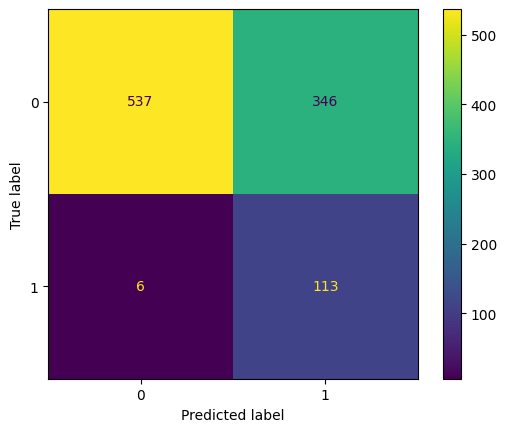

In [52]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

In [53]:
#after training
y_pred = rf.predict(X_test)

In [54]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with training: ", accuracy)

Accuracy with training:  0.9321357285429142


In [55]:
cm_after = confusion_matrix(y_test, y_pred)

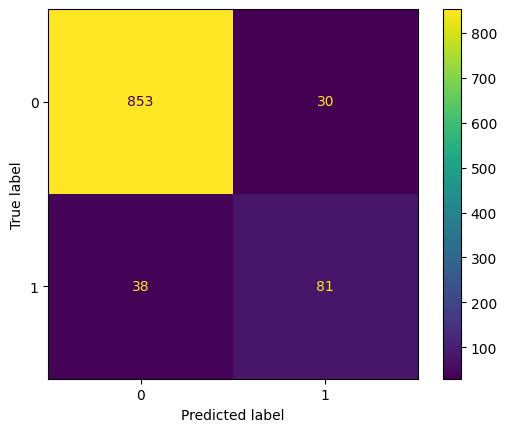

In [56]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_after)
cm_display.plot()
plt.show()

In [57]:
# define the threshold values
thresholds = np.arange(0.5, 0.025, -0.025)

In [58]:
# calculate the false positive and false negative for each threshold
fp = []
fn = []
y_pred_proba = rf.predict_proba(X_test)[:, 1] # get predicted probabilities for positive class

In [59]:
for th in thresholds:
    y_pred = (y_pred_proba >= th).astype(int)
    tn, fp_, fn_, tp = confusion_matrix(y_test, y_pred).ravel()
    fp.append(fp_)
    fn.append(fn_)

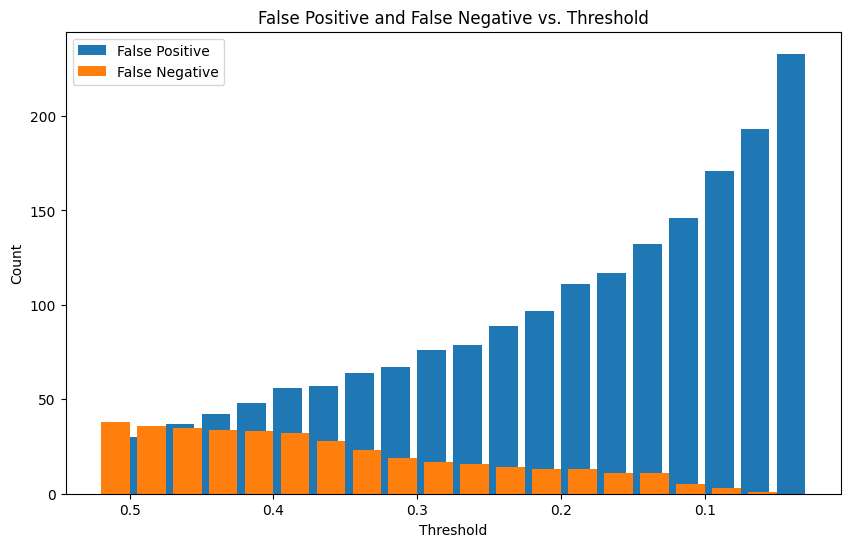

In [60]:
# plot the histogram
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(thresholds, fp, width=-0.02, align='edge', label='False Positive')
ax.bar(thresholds, fn, width=0.02, align='edge', label='False Negative')
ax.set_xlabel('Threshold')
ax.set_ylabel('Count')
ax.invert_xaxis()
ax.set_title('False Positive and False Negative vs. Threshold')
ax.legend()
plt.show()

In [61]:
# parameter optimization
param = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

In [62]:
# 10 fold cross validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param, n_iter=50,
                                   cv=10, scoring='accuracy', n_jobs=-1, random_state=42)

In [63]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D551CDD90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D5579F790>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D5578E2D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D5557BE90>},
                   random_state=42, scoring='accuracy')

In [64]:
# best rf model
best_rf = random_search.best_estimator_

In [65]:
# applying best_rf model to test set with low threshold = no false negatives 
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.05).astype(int)

In [66]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with training: ", accuracy)

Accuracy with training:  0.7734530938123753


In [67]:
cm_after = confusion_matrix(y_test, y_pred)

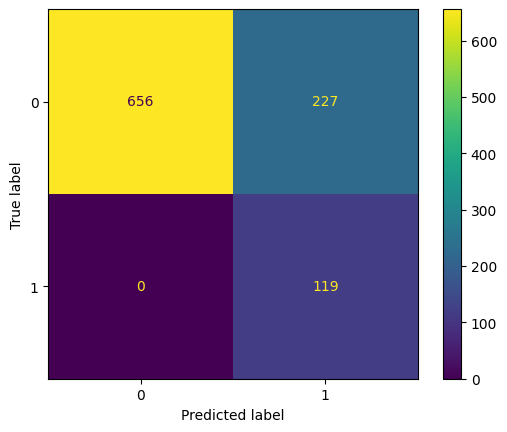

In [68]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_after)
cm_display.plot()
plt.show()